## Based on https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb

# Attention on VGGNet (Saliency and grad-CAM)

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
from keras.models import load_model
import numpy as np
from vis.utils import utils
from keras import activations
import random

model = load_model('whale.flukes.4250_classes.weights.best.hdf5')

prediction_layer = 'dense_6'
layer_idx = utils.find_layer_idx(model, prediction_layer)
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

all_classes = np.load('train_classes.npy')

num_classes = len(all_classes)

target_size = (150, 150)

Using TensorFlow backend.


Lets load a couple of test images to try saliency.

Whale id w_f6086ac


/home/ubuntu/anaconda3/envs/whale-id/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/whale-id/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


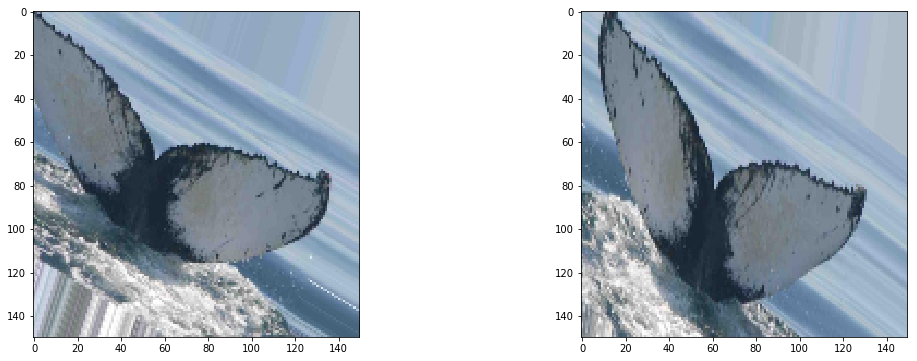

In [2]:
from vis.utils import utils
from matplotlib import pyplot as plt
import glob

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

whale_id = random.sample(list(all_classes), 1)[0]
whale_index = np.where(all_classes==whale_id)[0][0]

print(f'Whale id {whale_id}')

files = glob.glob(f'data/test/{whale_id}/*')
if len(files) < 2:
    files.append(files[0])
    
img1 = utils.load_img(files[0], target_size=target_size)
img2 = utils.load_img(files[1], target_size=target_size)

f, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[1].imshow(img2)

Time for saliency visualization.

InvalidArgumentError: input_1_1:0 is both fed and fetched.

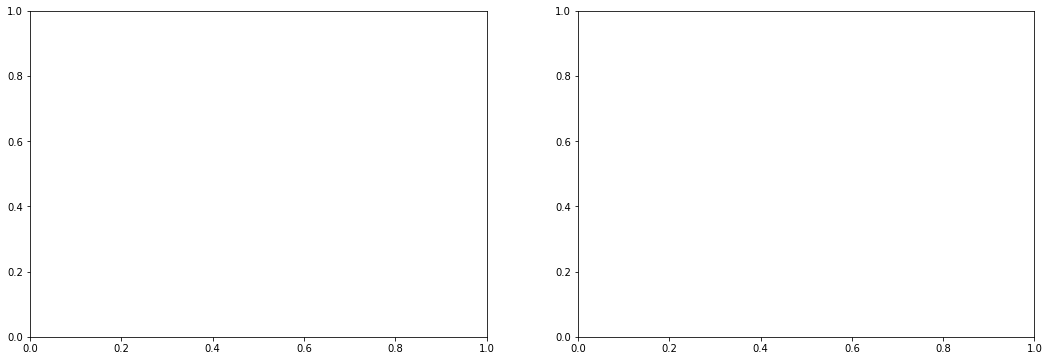

In [3]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    grads = visualize_saliency(model, layer_idx, filter_indices=whale_index, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`.

In [ ]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_saliency(model, layer_idx, filter_indices=whale_index, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

guided saliency is definitely better. I am not sure whats going on with rectified saliency.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `block5_pool` layer after all the `Conv` layers. Here is the model summary for reference.

In [ ]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=whale_index, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        #ax[i].imshow(overlay(jet_heatmap, img)) https://github.com/raghakot/keras-vis/issues/73
        ax[i].imshow(overlay(grads, img))